In [1]:
import os
import sys
import numpy as np
import collections
import argparse
from numpy import ones, tile
from mcbits import coders, util
from models.toy_model import ToyModel
import random

exp_name = "initial_bits_plot_toy_mixture"
dir_name = os.path.join('./save', exp_name)
if not os.path.exists(dir_name):
    os.makedirs(dir_name)

# Arguments

In [2]:
# toy experiment parameters, use smaller values to get results faster
alphabet_size = 64
latent_alphabet_size = 256
message_length = 1  # use message length = 1 to quantify initial bit cost
sample_size = 100

# rANS stack parameters
mprec = 16
bprec = 32
lprec = 32
log_max = 7

# Toy Model

In [3]:
np.random.seed(1234)
random.seed(1234)

# model
model = ToyModel(latent_alphabet_size, alphabet_size)

# uniform distribution as posterior
prop_counts = (ones((latent_alphabet_size, alphabet_size))
                   / latent_alphabet_size)

# Count Stat Funcs

In [4]:
prior_count_stat_func_cache = util.Categorical(mprec, model.z_probs, use_make_sum_to_M=True)

def get_prior_count_stat_func():
    return prior_count_stat_func_cache

prop_count_stat_func_cache = {}
def get_prop_count_stat_func(x):
    if x in prop_count_stat_func_cache:
        return prop_count_stat_func_cache[x]
    else:  
        stat_func = util.Categorical(mprec, prop_counts[:, x], use_make_sum_to_M=True)
        prop_count_stat_func_cache[x] = stat_func
        
        return stat_func

cond_count_stat_func_cache = {}
def get_cond_count_stat_func(z): 
    if z in cond_count_stat_func_cache:
        return cond_count_stat_func_cache[z]
    else:
        stat_func = util.Categorical(mprec, model.cond_probs[z], use_make_sum_to_M=True)
        cond_count_stat_func_cache[z] = stat_func
        
        return stat_func
    
joint_count_stat_func_cache_z = {}
joint_count_stat_func_cache_x = {}

def get_joint_count_stat_func(z=None, x=None):
    if z is not None and x is None:
        if z in joint_count_stat_func_cache_z:
            return joint_count_stat_func_cache_z[z]
        else:
            stat_func = util.Categorical(mprec, model.joint_probs[z], use_make_sum_to_M=True)
            joint_count_stat_func_cache_z[z] = stat_func
            
            return stat_func
    elif x is not None and z is None:
        if x in joint_count_stat_func_cache_x:
            return joint_count_stat_func_cache_x[x]
        else:
            stat_func = util.Categorical(mprec, model.joint_probs[:, x], use_make_sum_to_M=True)
            joint_count_stat_func_cache_x[x] = stat_func
            
            return stat_func
    else:
        raise Exception("Bad arg to joint_count_stat_func_fn.")

# BB-ELBO Coder

## Compute total bitrate for a single symbol

In [5]:
coder_class = coders.BitsBackCoder

coder_kwargs = {
    "get_prior_count_stat_func": get_prior_count_stat_func,
    "get_prop_count_stat_func": get_prop_count_stat_func,
    "get_cond_count_stat_func": get_cond_count_stat_func,
    "mprec": mprec, "lprec": lprec, "bprec": bprec, "multidim": False, "use_statfunc": False,
}

true_bits_bitsback = 0.0

for _ in range(sample_size):
    message = model.sample_message(message_length)
    
    initial_x = np.random.randint(1 << lprec, 1 << (lprec + bprec) - 1)
    coder_kwargs['initial_x'] = initial_x
    
    coder = coder_class(**coder_kwargs)
    coder.encode(message)
    
    true_bits_bitsback += coder.bit_length / message_length

true_bits_bitsback /= sample_size

print(f"BB")
print(f"\ttrue bit length : {true_bits_bitsback}")

BB
	true bit length : 67.96460620255293


## Save

In [6]:
np.save(os.path.join(dir_name, "true_bits_bitsback"), np.array([true_bits_bitsback]))

# BB-AIS Coder

## Compute total bitrate for a single symbol vs AIS steps

In [7]:
ais_steps_array = list(2 ** np.arange(log_max+1))
print(ais_steps_array)

[1, 2, 4, 8, 16, 32, 64, 128]


In [8]:
coder_class = coders.AISBitsBackCoder

# adjust coder kwargs for AIS coder
coder_kwargs = {
    "get_prior_count_stat_func": get_prior_count_stat_func,
    "get_prop_count_stat_func": get_prop_count_stat_func,
    "get_cond_count_stat_func": get_cond_count_stat_func,
    "get_joint_count_stat_func": get_joint_count_stat_func,
    "mprec": mprec, "lprec": lprec, "bprec": bprec, "multidim": False, "use_statfunc": False,
}


true_bits_ais_bitsback_array = []
true_bits_ais_bitsback_bitswap_array = []

for ais_steps in ais_steps_array:
    coder_kwargs["betas"] = np.flip(np.linspace(0, 1, ais_steps+1))
    
    true_bits_ais_bitsback = 0.0
    true_bits_ais_bitsback_bitswap = 0.0
    for _ in range(sample_size):
        message = model.sample_message(message_length)
        initial_x = np.random.randint(1 << lprec, 1 << (lprec + bprec) - 1)
        coder_kwargs['initial_x'] = initial_x
        
        coder_kwargs["bitswap"] = False
        coder = coder_class(**coder_kwargs)
        coder.encode(message)
        true_bits_ais_bitsback += coder.bit_length / message_length

        coder_kwargs["bitswap"] = True
        coder = coder_class(**coder_kwargs)
        coder.encode(message)
        true_bits_ais_bitsback_bitswap += coder.bit_length / message_length
    
    true_bits_ais_bitsback /= sample_size
    true_bits_ais_bitsback_bitswap /= sample_size
    
    print(f"AIS STEPS={ais_steps}")
    print(f"\ttrue bit length : {true_bits_ais_bitsback}")
    print(f"\ttrue bit length (bitswap) : {true_bits_ais_bitsback_bitswap}")
    

    true_bits_ais_bitsback_array.append(true_bits_ais_bitsback)
    true_bits_ais_bitsback_bitswap_array.append(true_bits_ais_bitsback_bitswap)

AIS STEPS=1
	true bit length : 67.72950504407949
	true bit length (bitswap) : 67.72950504407949
AIS STEPS=2
	true bit length : 67.7292709542255
	true bit length (bitswap) : 67.7292709542255
AIS STEPS=4
	true bit length : 86.8365847324839
	true bit length (bitswap) : 67.63176274488697
AIS STEPS=8
	true bit length : 109.77863509771076
	true bit length (bitswap) : 67.61601533848857
AIS STEPS=16
	true bit length : 166.8243284025296
	true bit length (bitswap) : 67.69073536388123
AIS STEPS=32
	true bit length : 281.85598807821583
	true bit length (bitswap) : 67.53540309952622
AIS STEPS=64
	true bit length : 511.7909990366486
	true bit length (bitswap) : 67.74740449228383
AIS STEPS=128
	true bit length : 967.6237525116933
	true bit length (bitswap) : 67.50294192151709


## Save

In [9]:
np.save(os.path.join(dir_name, "true_bits_ais_bitsback_array"), np.array(true_bits_ais_bitsback_array))
np.save(os.path.join(dir_name, "true_bits_ais_bitsback_bitswap_array"), np.array(true_bits_ais_bitsback_bitswap_array))

# BB-IS Coder

## Compute total bitrate for a single symbol vs # particles

In [10]:
num_particles_array = list(2 ** np.arange(log_max+1))
print(num_particles_array)

[1, 2, 4, 8, 16, 32, 64, 128]


In [11]:
coder_class = coders.ISBitsBackCoder

coder_kwargs = {
    "get_prior_count_stat_func": get_prior_count_stat_func,
    "get_prop_count_stat_func": get_prop_count_stat_func,
    "get_cond_count_stat_func": get_cond_count_stat_func,
    "mprec": mprec, "lprec": lprec, "bprec": bprec, "multidim": False, "use_statfunc": False,
}


true_bits_is_bitsback_array = []

for num_particles in num_particles_array:
    coder_kwargs["num_particles"] = num_particles
    
    true_bits_is_bitsback = 0.0
    for _ in range(sample_size):
        message = model.sample_message(message_length)
        initial_x = np.random.randint(1 << lprec, 1 << (lprec + bprec) - 1)
        coder_kwargs['initial_x'] = initial_x
        
        coder = coder_class(**coder_kwargs)
        coder.encode(message)
        true_bits_is_bitsback += coder.bit_length / message_length
    
    true_bits_is_bitsback /= sample_size
    
    print(f"IS # Particles={num_particles}")
    print(f"\ttrue bit length : {true_bits_is_bitsback}")

    true_bits_is_bitsback_array.append(true_bits_is_bitsback)

IS # Particles=1
	true bit length : 67.74550546876971
IS # Particles=2
	true bit length : 67.78875783363117
IS # Particles=4
	true bit length : 99.61099167001692
IS # Particles=8
	true bit length : 131.54786816528255
IS # Particles=16
	true bit length : 195.35710752068567
IS # Particles=32
	true bit length : 323.72393843005256
IS # Particles=64
	true bit length : 579.5525251794246
IS # Particles=128
	true bit length : 1091.5412329410642


## Save

In [12]:
np.save(os.path.join(dir_name, "true_bits_is_bitsback_array"), np.array(true_bits_is_bitsback_array))

# BB-CIS Coder

## Compute total bitrate for a single symbol vs # particles

In [13]:
coder_class = coders.CISBitsBackCoder

# for cis, we use shift sampling operators to generate other latents
def shift_sampling(shift, precision):
    assert 0.0 <= shift <= 1.0
    upper = 1 << precision
    shift_scaled = int(shift * upper)

    def operator(u, prop_count_stat_func):
        return (u + shift_scaled) % upper

    def inverse_operator(u, prop_count_stat_func):
        return (u - shift_scaled) % upper

    return (operator, inverse_operator)


coder_kwargs = {
    "get_prior_count_stat_func": get_prior_count_stat_func,
    "get_prop_count_stat_func": get_prop_count_stat_func,
    "get_cond_count_stat_func": get_cond_count_stat_func,
    "mprec": mprec, "lprec": lprec, "bprec": bprec, "multidim": False, "use_statfunc": False,
}


true_bits_cis_bitsback_array = []

for num_particles in num_particles_array:    
    sampling_shifts = np.random.rand(num_particles-1,)
    sampling_shifts = np.insert(sampling_shifts, 0, 0.0)
    shift_sampling_operators = [shift_sampling(shift, mprec) for shift in sampling_shifts]
    
    
    coder_kwargs["num_particles"] = num_particles
    coder_kwargs["bijective_operators"] = shift_sampling_operators
    
    true_bits_cis_bitsback = 0.0
    for _ in range(sample_size):
        message = model.sample_message(message_length)
        initial_x = np.random.randint(1 << lprec, 1 << (lprec + bprec) - 1)
        coder_kwargs['initial_x'] = initial_x
        
        coder = coder_class(**coder_kwargs)
        coder.encode(message)
        true_bits_cis_bitsback += coder.bit_length / message_length
    
    true_bits_cis_bitsback /= sample_size
    
    
    print(f"CIS # Particles={num_particles}")
    print(f"\ttrue bit length : {true_bits_cis_bitsback}")

    true_bits_cis_bitsback_array.append(true_bits_cis_bitsback)

CIS # Particles=1
	true bit length : 67.90654705016895
CIS # Particles=2
	true bit length : 67.80728456023138
CIS # Particles=4
	true bit length : 67.5068214536844
CIS # Particles=8
	true bit length : 67.50704974494742
CIS # Particles=16
	true bit length : 67.4960565969114
CIS # Particles=32
	true bit length : 67.87569015547597
CIS # Particles=64
	true bit length : 67.69622375795912
CIS # Particles=128
	true bit length : 68.15332863088062


## Save

In [14]:
np.save(os.path.join(dir_name, "true_bits_cis_bitsback_array"), np.array(true_bits_cis_bitsback_array))

# Load

In [15]:
# BB-ELBO
true_bits_bitsback = np.load(os.path.join(dir_name, "true_bits_bitsback.npy"))[0]

# BB-AIS
true_bits_ais_bitsback_array = np.load(os.path.join(dir_name, "true_bits_ais_bitsback_array.npy"))
true_bits_ais_bitsback_bitswap_array = np.load(os.path.join(dir_name, "true_bits_ais_bitsback_bitswap_array.npy"))

# BB-IS
true_bits_is_bitsback_array = np.load(os.path.join(dir_name, "true_bits_is_bitsback_array.npy"))

# BB-CIS
true_bits_cis_bitsback_array = np.load(os.path.join(dir_name, "true_bits_cis_bitsback_array.npy"))

# Plot

In [16]:
from matplotlib import rc
from matplotlib import pyplot as plt

# rc('text', usetex=True)
# rc('font',**{'size':10, "family" : "serif", "serif" : "Times"})
# rc('text.latex', preamble=r'\usepackage{amsfonts}')
# plt.style.use('default')

In [17]:
plot_max = 8

plot_marker_style = {'marker': 'o', 'markersize': 3}
scatter_marker_style = {'marker': 'x', 's': 60}

## Initial Bits Plot

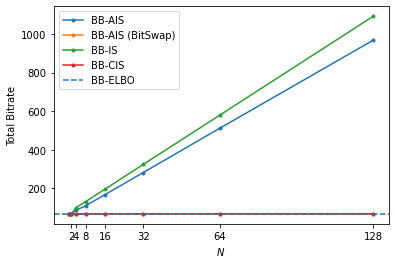

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1)
bb_ais, = ax.plot(ais_steps_array[:plot_max], true_bits_ais_bitsback_array[:plot_max], label=r'BB-AIS', **plot_marker_style)
bb_ais_bitswap, = ax.plot(ais_steps_array[:plot_max], true_bits_ais_bitsback_bitswap_array[:plot_max], label=r'BB-AIS (BitSwap)', **plot_marker_style)
bb_is, = ax.plot(num_particles_array[:plot_max], true_bits_is_bitsback_array[:plot_max], label=r'BB-IS', **plot_marker_style)
bb_cis, = ax.plot(num_particles_array[:plot_max], true_bits_cis_bitsback_array[:plot_max], label=r'BB-CIS', **plot_marker_style)
bb_elbo = ax.axhline(true_bits_bitsback, label=r'BB-ELBO', ls='--')

ax.legend(frameon=True)
ax.set_xlabel(r'$N$')
ax.set_ylabel('Total Bitrate')
# ax.set_xscale('log', basex=2)
ax.set_xticks(num_particles_array[1:plot_max])
plt.legend()

plt.show()